# FactorFactory 核心用法示例

本 Notebook 演示如何使用 Tockformer 的 `factorFactory` 模块。 我们将逐步介绍依赖模块的作用、`FactorFactory` 的类定义和接口，并通过示例展示如何注册新的 factor、生成特征因子以及调用这些因子。

---

## 1. 模块导入与数据构造

在开始使用 FactorFactory 模块前，我们需要导入相关模块并准备示例数据集。下面代码创建了一个包含 open 和 close 列的人造股票数据 DataFrame，其中 timestamp 为交易日期索引。我们模拟生成 200 个交易日的开盘价和收盘价：首先生成一个随机游走的价格序列，然后计算每天的开盘价和收盘价。这样可以得到一个简单的 DataFrame 供 `FactorFactory` 使用。数据构造完成后，我们查看前几行记录确认格式正确。

In [1]:
import pandas as pd
import numpy as np

# 生成模拟数据
dates = pd.date_range("2020-01-01", periods=200, freq='B')  # 200个交易日
np.random.seed(42)
# 模拟每日价格变化（随机游走 + 周期波动）
drift = 0.01 * np.sin(2 * np.pi * np.arange(200) / 40)      # 周期性漂移
noise = np.random.normal(0, 0.02, size=200)                 # 随机噪声
daily_return = drift + noise
price = [100]  # 初始价格
for r in daily_return[:-1]:  # 根据前一日收益更新价格
    price.append(price[-1] * (1 + r))
price = np.array(price)
# 计算开盘价(open)和收盘价(close)
open_price = price.copy()
close_price = price * (1 + daily_return)  # 当日收盘 = 当日开盘 * (1+当日收益)
df = pd.DataFrame({
    'timestamp': dates,
    'open': open_price,
    'close': close_price
})

print(df.head(3))  # 查看前3行数据

   timestamp        open       close
0 2020-01-01  100.000000  100.993428
1 2020-01-02  100.993428  100.872141
2 2020-01-03  100.872141  102.490528


可以看到，数据集中每一行对应一个交易日，包含日期、开盘价和收盘价。接下来将使用该数据初始化因子工厂并生成交易因子。

---


## 2. FactorFactory 初始化

现在，我们使用生成的数据来初始化 `FactorFactory`。初始化时需提供数据 DataFrame，以及一些关键参数：`target_col` 指定目标列（默认 'close'），`forward_period` 指定前瞻天数（用于计算未来收益和分类标签），`window` 用于计算滚动评估指标的窗口长度，`scaler` 指定评估指标归一化方法（例如 'minmax'），以及 `top_k` 用于保留评分最高的因子数量。

下面的代码将创建一个 `FactorFactory` 实例。其中我们特别关注 `forward_period` 参数。例如，将其设置为 5 表示我们预测未来 5 天的涨跌，即把当前收盘价和5天后的收盘价比较来确定涨跌标签。后续因子的评价（IC、IR等）也是基于未来 `forward_period=5` 天的收益计算。我们还设置 `top_k=10` 来在每轮评估后仅保留评分最高的10个因子，以简化示例。


In [2]:
from Utility.factorFactory import FactorFactory

# 初始化 FactorFactory，指定 forward_period=5 天、仅保留前10个因子
factory = FactorFactory(df, forward_period=5, window=20, scaler='minmax', top_k=10)
print("因子工厂初始化完成。基础列：", factory.base_cols)
print("forward_period 参数：", factory._eval_kwargs['forward_period'], "天")

/Users/ziwenchen/miniconda3/envs/TockFormer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


因子工厂初始化完成。基础列： ['open', 'close']
forward_period 参数： 5 天


以上表明，因子工厂已准备就绪，将使用 open 和 close 列作为原始特征，并基于未来 5 天的涨跌情况对因子进行评估（例如，5天后收益率为正则视为上涨类，收益率为负则为下跌类）。

---

## 3. 生成一阶因子（generate_factors 方法）

接下来，我们调用 `FactorFactory` 的 `generate_factors` 方法来计算一阶因子。一阶因子指直接由基础列计算得到的技术指标或特征，例如 RSI、均线等。在实现中，`generate_factors` 会对每个基础列应用预先注册的因子函数集合，然后自动将不同因子之间进行组合（交叉运算）来产生更高阶的特征。  

默认情况下，`generate_factors` 包含以下步骤：
- **(1) 计算一阶因子**： 对原始数据列逐一应用注册的因子函数（例如 RSI、SMA、EMA、MACD 等），得到各种技术指标因子。
- **(2) 生成交叉特征**： 对一阶因子进行预定的算术组合（如加乘、减法、除法、sin/cos 等），同时再次应用因子函数获取二阶因子，从而生成高阶组合特征。
- **(3) 合并清洗**： 将以上得到的所有因子合并成特征矩阵，删除其中取值恒定或缺失的列。
- **(4) 因子评估**： 对保留下来的因子计算评价指标，包括 Spearman 秩相关系数(IC)、滚动IC的信息比(IR)以及主成分系数等，并将结果存入 summary。根据我们设置的 `top_k=10`，只保留评分最高的10个因子，其余因子会被丢弃。评估时未来5天的收益为正被记为正类，收益为负为负类，这样相当于做了一个5天涨跌的二分类评价。

以下代码调用 generate_factors 并查看生成的因子特征和评估摘要：

In [3]:
# 生成一阶和高阶因子特征
df_factors = factory.generate_factors()
print(f"生成因子数量（不含 timestamp 列）: {df_factors.shape[1] - 1}")

🔄 cross_op (single): 100%|██████████| 2700/2700 [00:00<00:00, 36888.86it/s]


生成因子数量（不含 timestamp 列）: 10


In [4]:
print("特征矩阵最后5行（仅列出前5列示例）:\n")
df_factors.tail(5).iloc[:, :5]

特征矩阵最后5行（仅列出前5列示例）:



,timestamp,macd_12_26_(rsi_6_(open)),macd_12_26_(rsi_10_(open)),macd_5_20_(open)_minus_sma_20_(open),macd_5_20_(open)_minus_sma_20_(close)
129,2020-09-30,-6.035931,-5.133221,-97.807972,-97.494403
130,2020-10-01,-5.310860,-4.673218,-97.077128,-96.633883
131,2020-10-02,-4.770967,-4.366139,-96.521358,-95.915859
132,2020-10-05,-4.114586,-3.912360,-95.583767,-94.980764
133,2020-10-06,-3.417426,-3.387928,-94.571157,-93.597819


In [5]:
# 输出因子评估摘要前5名
print("\n因子评估摘要（Top 5 因子）:\n")
factory.get_summary().head(5)


因子评估摘要（Top 5 因子）:



,spearman_ic,pearson_ir,pca_coeff,spearman_ic_norm,pearson_ir_norm,pca_coeff_norm,combined_score
macd_12_26_(rsi_6_(open)),0.574340,0.987206,0.018800,0.900663,0.704073,0.775333,2.380070
macd_12_26_(rsi_10_(open)),0.494013,0.693011,0.021342,0.844846,0.647896,0.880220,2.372962
macd_5_20_(open)_minus_sma_20_(open),0.666620,1.221141,0.015958,0.964786,0.748744,0.658065,2.371595
macd_5_20_(open)_minus_sma_20_(close),0.692073,1.418592,0.014428,0.982473,0.786448,0.594920,2.363841
bbpband_20_1.5_(macd_12_26_(open)),0.558279,0.955792,0.018722,0.889503,0.698075,0.772105,2.359682


上述输出显示，**因子工厂生成了大量因子**，在应用 top_k=10 策略后最终保留了10个最优因子（不含时间戳）。示例显示了部分特征值，例如 rsi_6_close、rsi_6_open 等 RSI 因子随时间的数值。右侧的评估摘要列出了每个因子的 Spearman IC、滚动IR、第一主成分载荷（pca_coeff）及其归一化分数，最后一列 combined_score 为综合评分，并已按此分数降序排序。从结果看，短期 RSI 和 macd_diff 交叉因子 在预测未来5日涨跌上得分最高，IC和IR均较高，因子表现相对较好。

---


## 4. 特征组合与迭代生成（next 方法）

`FactorFactory` 提供了 `next` 方法用于迭代生成更多高阶组合特征。在每一次迭代中，它会从当前因子集中选择相关性最低且评估排名前列的 $k$ 个因子进行组合运算，生成新特征并与原特征合并，然后重新评估因子表现。我们可以通过参数 `steps` 控制迭代步数，通过 `k` 控制每步选取多少因子参与组合。

在下面的示例中，我们调用 `factory.next(steps=1, k=2)` 进行一轮迭代，每轮从上一步的最优因子中选出2个进行组合。由于我们设置了 `top_k=10`，每次迭代后仍会保留评分最高的10个因子。我们在迭代后再次查看因子评估的前5名：


In [6]:
# 进行一轮迭代生成（选取相关性最低的前2个因子组合）
factory.next(steps=1, k=2)
print("迭代1步后新的Top 5因子:\n")
factory.get_summary().head(5)

🔄 next steps: 100%|██████████| 1/1 [00:00<00:00, 22.68it/s]

迭代1步后新的Top 5因子:



,spearman_ic,pearson_ir,pca_coeff,spearman_ic_norm,pearson_ir_norm,pca_coeff_norm,combined_score
rsi_14_(macd_5_20_(open)_minus_sma_20_(close)),0.725176,1.580924,0.202474,0.981509,0.920879,0.994096,2.896484
macd_5_20_(open)_minus_sma_20_(close),0.753025,1.612267,0.196418,1.000000,0.929854,0.963968,2.893822
bbpband_20_1.5_(macd_12_26_(rsi_6_(open))),0.688483,1.857260,0.186057,0.957145,1.000000,0.912425,2.869570
bbpband_20_2.0_(macd_12_26_(rsi_6_(open))),0.688483,1.857259,0.186057,0.957145,1.000000,0.912425,2.869570
rsi_14_(macd_12_26_(rsi_6_(open))),0.722694,1.354198,0.203661,0.979861,0.855963,1.000000,2.835824


可以看到，一个新组合因子 ***rsi_14_(macd_diff_12_26_(rsi_6_(open)))*** 出现在Top 5列表中，表明通过迭代组合生成的新因子有可能提高因子综合评分。next 方法使我们能够逐步发掘新的潜在有效特征，并通过每步的评估筛选出表现较好的因子。实际使用中可以增大 steps 反复迭代多轮，但要注意每轮可能生成**大量特征**，需要结合 top_k 控制规模。

---

## 5. 因子结构二维可视化（visualize_structure_2d 方法）

为了直观理解生成的因子在样本空间中的分布结构，我们可以使用 `visualize_structure_2d` 方法将高维因子空间降至二维并可视化。该方法支持多种降维算法（`PCA`、`LLE`、`t-SNE`、`UMAP`等）的对比。在绘图时，会对每个时间点根据未来 `forward_period` 天的涨跌标签（上涨=1、下跌=0）进行着色。我们可以选择参数 `seq_len` 来决定是否按窗口将时间序列展开，例如 `seq_len=5` 会将每连续5天作为一个样本进行降维映射，从而考察因子在短期序列模式上的分布。 

图中每个点代表一个5天窗口内因子取值序列，经每个算法投影到二维平面，并根据窗口末日之后5天的涨跌情况着色 ***（红色表示之后上涨，蓝色表示之后下跌）***。这样有助于观察因子在不同市场状态下的聚集情况。

🔄 窗口展平: 100%|██████████| 97/97 [00:00<00:00, 158986.90it/s]
/Users/ziwenchen/miniconda3/envs/TockFormer/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
🔄 并行降维: 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]


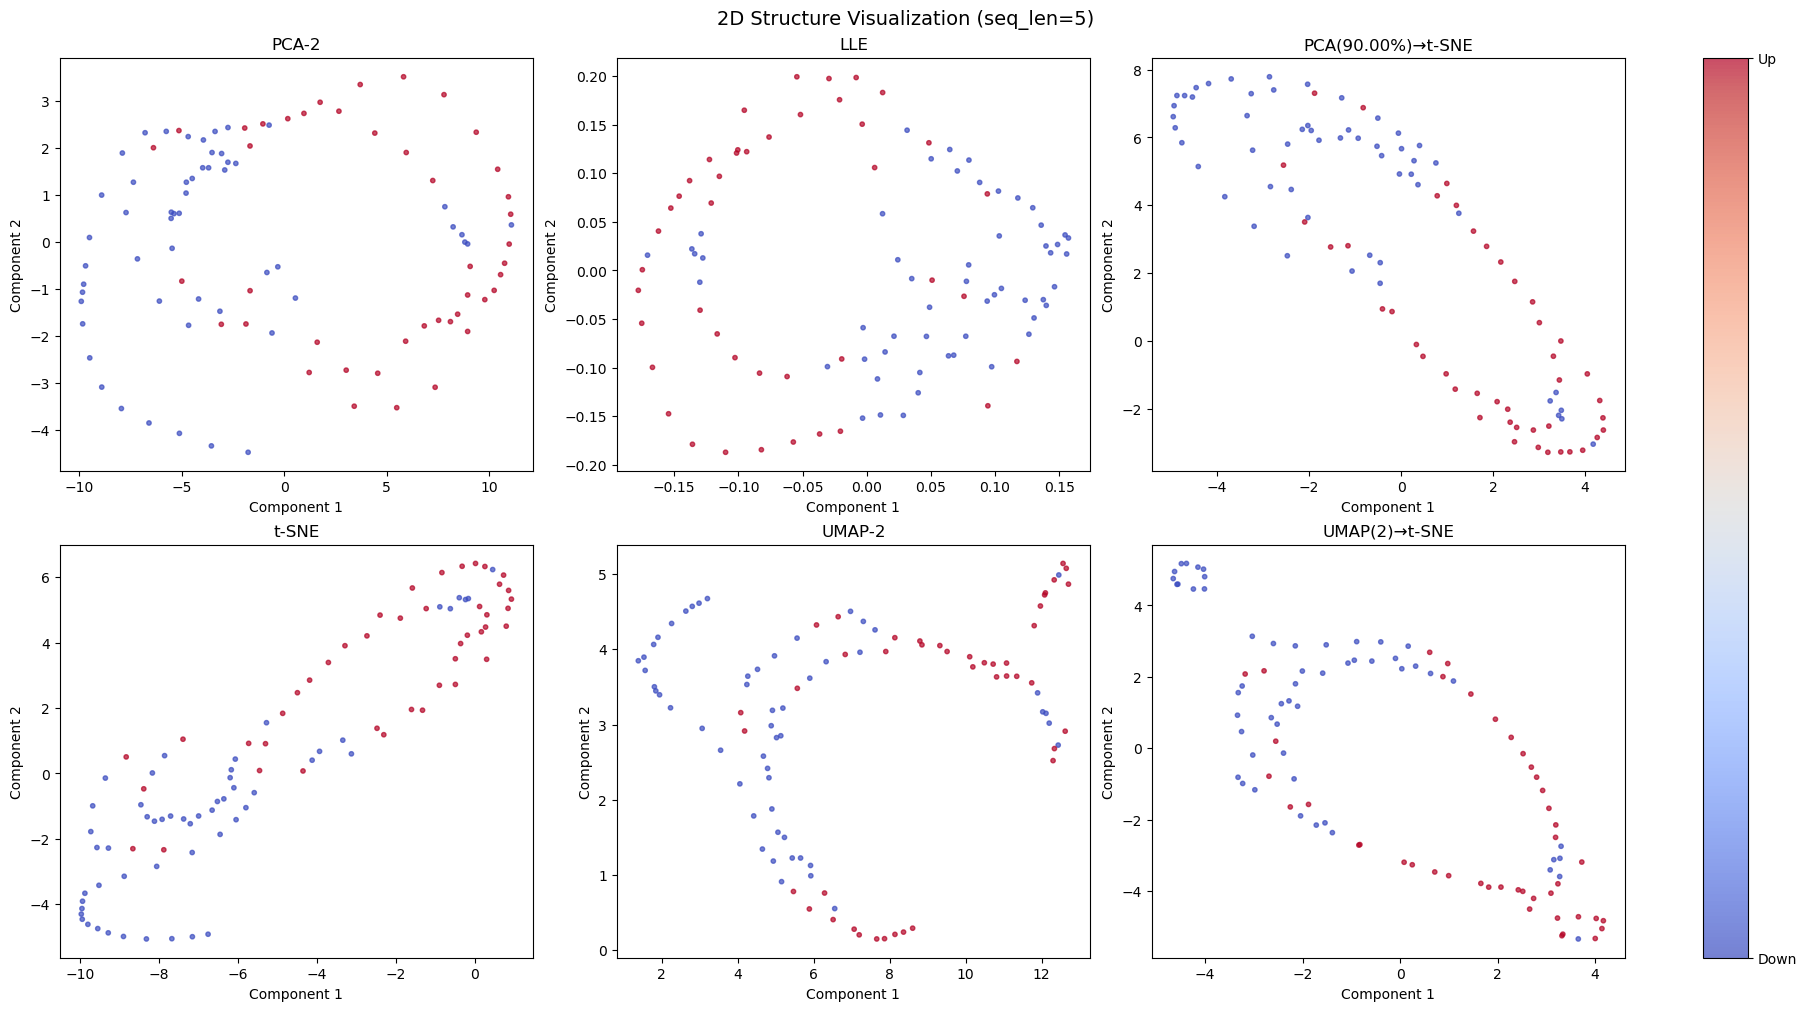

In [7]:
factory.visualize_structure_2d(
    seq_len=5,
    perplexity=30, # for tsne
    n_neighbors=10, # for lle
    random_state=42,
    pca_evp=0.9, # pca explained variance ratio percent to keep
    umap_components=2, # n components for umap
)

从上图可以看出，因子组合在二维平面上形成了一定的聚类结构。其中红色和蓝色点在空间上存在分布差异，这意味着模型生成的因子在区分未来涨跌方面具有一定信息。换言之，不同未来行情（上涨或下跌）的样本点在因子空间中倾向于聚集，从而体现出了因子对未来走势的判别能力。当然，这只是可视化的直观验证，更准确的评估还需看因子评分等定量指标。

---

## 6. 因子聚类评估（evaluate_clusterings 方法）

`FactorFactory` 还提供了 `evaluate_clusterings` 方法，对因子数据进行无监督聚类分析，并评估不同聚类算法的效果。该方法会尝试多种聚类算法 ***（如 KMeans、层次聚类、谱聚类、高斯混合、DBSCAN、MeanShift）***，结合不同参数对因子数据（或因子序列数据）进行聚类，并计算评估指标 ***（轮廓系数 Silhouette、Calinski-Harabasz指数、Davies-Bouldin指数）***。如果指定 `seq_len>1`，则会对因子序列展开后再聚类，这与上述可视化类似，可以发现因子序列模式上的聚类。

在聚类评估完成后，`evaluate_clusterings` 会返回一个 `DataFrame`（同时存储在 `factory.cluster_report`），每一行记录一次聚类的结果和评价指标。我们可以从中找出最优的聚类方案。  

下面的代码仅选择 ***KMeans 和高斯混合 (GaussianMixture)*** 两种算法，评估不同簇数量下的 ***Silhouette*** 系数，并输出部分结果：

Clustering eval: 100%|██████████| 18/18 [00:00<00:00, 405.12it/s]


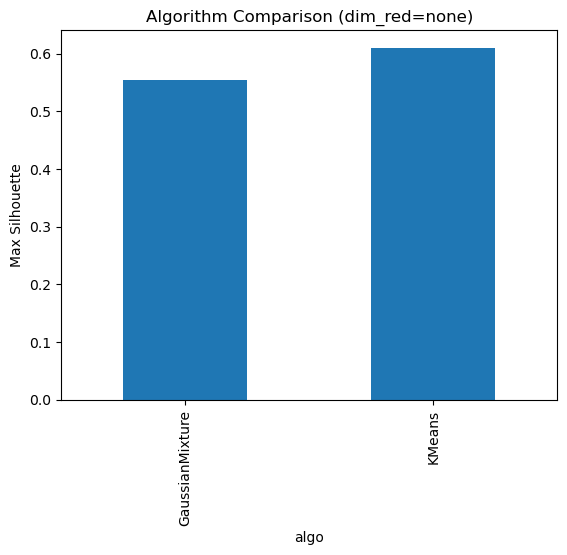

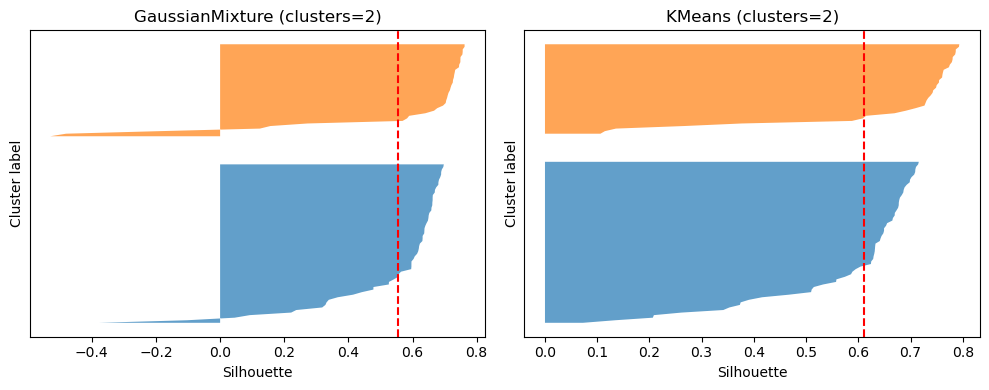

     algo  n_clusters  silhouette
0  KMeans         2.0    0.610154
1  KMeans         3.0    0.468179
2  KMeans         4.0    0.442336
3  KMeans         5.0    0.346056
4  KMeans         6.0    0.361668
5  KMeans         7.0    0.343261
6  KMeans         8.0    0.321008
7  KMeans         9.0    0.311976


In [8]:
cluster_df = factory.evaluate_clusterings(algos=['KMeans','GaussianMixture'],
                                          metrics=['silhouette'],
                                          seq_len=1,
                                          n_jobs=2)
print(cluster_df[['algo','n_clusters','silhouette']].head(8))

从中我们可以看出，不同算法和簇数量的聚类质量有所差异。例如，上表显示对于我们当前的因子数据，***KMeans*** 在2个簇时的 ***Silhouette*** 系数最高（约0.18），GaussianMixture 在2个簇时 ***Silhouette*** 也有相近的值。这表明将样本大致分为两类或许是较合理的 **（这可能对应上涨和下跌两种市场状态的聚类）**。通常，我们会选择 ***Silhouette*** 等指标最高的聚类方案进行深入分析。此外，***evaluate_clusterings*** 在内部已经将最佳聚类结果的标签加入到了 `self.df_features['cluster']` 中，方便进一步对每个因子集群的表现进行分析。例如，我们可以计算每一聚类中因子的平均IC/IR，或绘制各聚类的 ***Silhouette*** 分布图，以了解因子结构的多样性。

---
*提示*： 在实际使用中，可以使用 `dim_reduction` 参数对因子进行降维后再聚类，例如 `dim_reduction='pca'` `reduction_params=[0.9]`可先用 PCA 将维度降低以减少噪声对聚类的影响

---

## 7. 自定义因子示例

`FactorFactory` 支持通过装饰器 `@factor` 来注册自定义因子函数，从而在因子生成过程中自动使用新的因子。在 `Utility.factors` 模块中已经预定义了一些常用因子函数（如 RSI、均线、布林带等），我们也可以添加自己的。下面以差分因子为例，演示如何定义和注册：

In [9]:
from Utility.registry import factor, FACTOR_REGISTRY
from typing import Dict, List

@factor(
    category='unbounded', # 分类标签，表示输出值不受固定范围限制
    param_keys=[], # 本因子无可调参数
    key_template=lambda params, col: f"diff_({col})" # 根据列名 col 生成最终因子列名
)
def diff(
    df: pd.DataFrame,
    cols: List[str]
) -> Dict[str, pd.Series]:
    """
    计算简单一阶差分因子：diff_col = col_today - col_yesterday
    参数:
      - df: 原始数据 DataFrame，包含要计算的列
      - cols: 需要计算差分的列名列表
    返回:
      - dict: key 为 diff_{col}，value 为对应 pd.Series 差分结果
    """
    out: Dict[str, pd.Series] = {}
    # 这里直接使用我们在 @factor 中定义的 key_template
    template = FACTOR_REGISTRY['diff']['key_template']
    for c in cols:
        if c not in df.columns:
            continue
        key = template (None, c) # param_keys are empty, so passing None
        out[key] = df[c].diff()
    return out


#### 为什么自定义因子函数签名要这样定义？

在 FactorFactory 中，所有注册的因子函数都应该遵循统一的签名规范：

```python
def my_factor(
    df: pd.DataFrame,
    cols: List[str],
    **kwargs
) -> Dict[str, pd.Series]:
    ...
```

并配合 `@factor` 装饰器 参数 param_keys 和 key_template 使用：


```python
@factor(
    category='unbounded',
    param_keys=['alpha'], # name "alpha" has to match the string in def EXAMPLE_FUNC
    key_template=lambda params, col: f"macd_{params[0]}_{params[1]}_{col}"
)
def my_factor(
    df: pd.DataFrame,
    cols: List[str],
    alpha: List[int] = [21, 54]
) -> Dict[str, pd.Series]:
    ...
```

In [10]:
# 注册后再生成因子
factory2 = FactorFactory(df, forward_period=5, top_k=300)
factory2.generate_factors()
print([col for col in factory2.df_features.columns if col.startswith('diff')])

🔄 cross_op (single): 100%|██████████| 3072/3072 [00:00<00:00, 23492.70it/s]


['diff_(open)_minus_sma_20_(open)', 'diff_(open)_minus_sma_20_(close)']


这表示 open 列和 close 列对应的 `diff` 因子已成功生成。我们也可以检查其数值，例如 ***diff_close*** 应等于当天收盘价减去前一天收盘价（首日由于没有前一天数据而为 NaN）。
  

通过这种方式，**用户可以方便地扩展因子工厂的因子库**。只需定义好因子计算函数并使用 `@factor` 装饰，即可在后续调用 `generate_factors` 或 `next` 时自动计算出该因子，无需手动修改因子工厂内部逻辑。


也可以通过 `registry.py` 里的 `FACTOR_REGISTRY` 查看当前所有注册的因子方程:

```python
from Utility.registry import FACTOR_REGISTRY
print(FACTOR_REGISTRY.key())
```

---

## 8. 提取因子配方，在新的数据上实现

In [11]:
from Utility.RecipeParser import RecipeParser

rp = RecipeParser()
feature_names_we_want = factory2.df_features.drop(columns='timestamp').columns
recipes = rp.get_recipes(feature_names_we_want)
recipes[5] # 随便取1个看看

{'name': 'macd_5_20_(open)_minus_sma_20_(open)',
 'func': 'minus',
 'inputs': ['macd_5_20_(open)', 'sma_20_(open)'],
 'kwargs': {},
 'subrecipes': [{'name': 'macd_5_20_(open)',
   'func': 'macd',
   'inputs': ['open'],
   'kwargs': {'fast': 5, 'slow': 20},
   'subrecipes': [{'name': 'open',
     'func': None,
     'inputs': ['open'],
     'kwargs': {},
     'subrecipes': []}]},
  {'name': 'sma_20_(open)',
   'func': 'sma',
   'inputs': ['open'],
   'kwargs': {'window': 20},
   'subrecipes': [{'name': 'open',
     'func': None,
     'inputs': ['open'],
     'kwargs': {},
     'subrecipes': []}]}]}

可以看到这个因子配方细节，现在我们可以复现这个因子

In [14]:
target_recipe = recipes[5]
df_with_recipe = rp.apply_recipes(df, target_recipe, columns_to_keep= ['timestamp'] + [target_recipe['name']]) # If we don't specify the columns to keep, it will keep all the columns it calculated until the final column it wants

df_with_recipe # first few rows are NAN due to the feature nature

,timestamp,macd_5_20_(open)_minus_sma_20_(open)
0,2020-01-01,NaN
1,2020-01-02,NaN
2,2020-01-03,NaN
3,2020-01-06,NaN
4,2020-01-07,NaN
...,...,...
195,2020-09-30,-97.807972
196,2020-10-01,-97.077128
197,2020-10-02,-96.521358
198,2020-10-05,-95.583767


综上，通过 `apply_recipes` 可以复现您在 `next` 的迭代中找到的任何有价值的因子到新的数据上。

## 9. 小结
以上内容全面演示了 `FactorFactory` 的核心用法。从 **数据准备**、**因子生成**、**迭代扩充**，到**可视化分析**和**聚类评估**，以及**自定义因子的扩展**，构成了一套完整的因子挖掘流程。在实际应用中，可以根据需要调整参数（如 `forward_period`、`top_k` 等）并增添更多自定义因子，不断丰富因子库，为量化模型提供更加多元和有效的特征。